# SWOT L1B SLC applications

![](https://img.shields.io/badge/CNES-tutorial-%20?color=blue&labelColor=grey)

_Authors: Damien Desroches, Mathilde Siméon (CNES)_

### Objectives
This tutorial explains  
* What is the SLC radar product
* What are the interesting variables to visualize and how to use it

### Requirements
1. Download SWOT_L1B_HR_SLC_01\*\_320_078R_\* products
2. Run the notebook in `swot-training` environment


### Content
* [Products overview](#The-SLC-product)
* [Open and read SLC](#Open-and-read-SLC-product)
* [Visualize changes over time](#Observe-features-changes-across-time)




## The SLC product

### Description

The **Single Look Complex** data product (**SLC**) contains radar amplitude (related to backscattering) and phase (related to height) information gridded in radar range geometry.

<div>
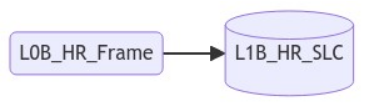
</div>

### When to use it ?
Because SWOT L2 processing is only made over water detected pixels, other measurements are pruned in L2 products. 
Hence, SLC product gives access to the full SWOT measurement. 

It can be useful for :
 - Study of the backscaterring behaviour in Ka band (change detection...)
 - Need for "raw" product in order to reprocess interferometric chain (water detection, phase unwrapping, ...)
 - Developing and tuning alternative methods for water detection, flagging...
    
### Associated issues
As it is a L1 product, it is quite heavy and its processing can be very complex
 - you need to reference DME, correct for phase screen...
 - there are power variations from radar (pixel size variation, antenna gain, etc...) to take into account to access to the sigma0
 - there is no geolocation, the coordinates are azimuth and range sampling.
 

## Libraries and setup

In [1]:
import os 
import glob
import re
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
from scipy.signal import convolve2d
import scipy

In [2]:
output_path = "/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC"

## Open and read SLC product

In [3]:
slc_name = "SWOT_L1B_HR_SLC_018_320_078R_20240721T080436_20240721T080447_PIC0_02.nc"

Opening the file without specifying groups gives access to metadata in attributes section

In [4]:
ds_root = xr.open_dataset(os.path.join(output_path, slc_name))
ds_root

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/66)
    Conventions:                   CF-1.7
    title:                         Level 1B KaRIn High Rate Single Look Compl...
    source:                        Ka-band radar interferometer
    history:                       2024-07-29T18:12:02Z : Creation
    platform:                      SWOT
    references:                    V1.2.3
    ...                            ...
    xref_events_param_file:        SWOT_Param_EVENTS_20000101T000000_20991231...
    xref_refdem_file:              SWOT_RefDEM_Nom_320_078R_20000101T000000_2...
    xref_reforbittrack_files:      SWOT_RefOrbitTrackTileBoundary_Nom_2000010...
    ellipsoid_semi_major_axis:     6378137.0
    ellipsoid_flattening:          0.0033528106647474805
    institution:                   CNES

In [5]:
ds = xr.open_dataset(os.path.join(output_path, slc_name),group="slc", decode_times=False)  

In [6]:
slc_plus_y = ds['slc_plus_y'][:,:,0]+1j*ds['slc_plus_y'][:,:,1]
slc_minus_y = ds['slc_minus_y'][:,:,0]+1j*ds['slc_minus_y'][:,:,1]

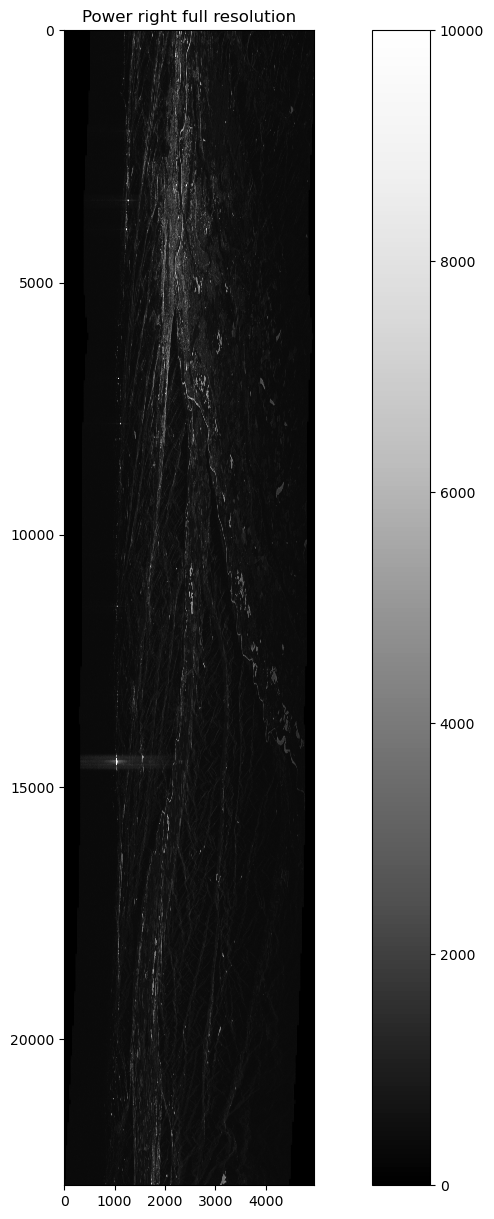

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(slc_plus_y), cmap="Greys_r", vmin=0, vmax= 1e4)
plt.title("Power right full resolution")
plt.colorbar()

In [12]:
slc_plus_y_ml = convolve2d(ds['slc_plus_y'][:,:,0]+1j*ds['slc_plus_y'][:,:,1], np.ones([7,1])/7.)[::7,:]
slc_minus_y_ml = convolve2d(ds['slc_minus_y'][:,:,0]+1j*ds['slc_minus_y'][:,:,1], np.ones([7,1])/7.)[::7,:]

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(slc_plus_y_ml), cmap="Greys_r", vmin=0, vmax= 1e3)
plt.title("Power right azimuth multilooking")
plt.colorbar()

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(slc_plus_y_ml), cmap="Greys_r", vmin=0, vmax= 1e3)
plt.title("Power right azimuth multilooking")
plt.colorbar()

Text(0.5, 1.0, 'Interferometric phase (flattened)')

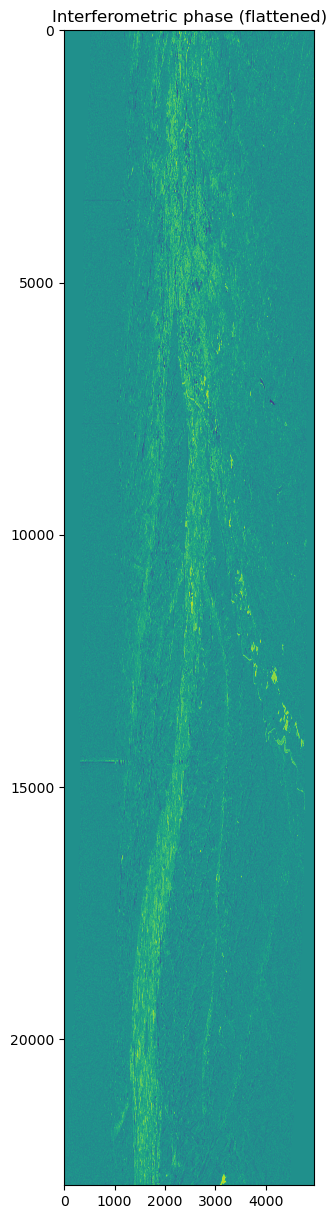

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(np.angle(slc_plus_y*np.conjugate(slc_minus_y)))
plt.title("Interferometric phase (flattened)")

In [16]:
num = scipy.signal.convolve2d(slc_plus_y*np.conjugate(slc_minus_y), np.ones([3,3]), 'same')
den1 = scipy.signal.convolve2d(np.abs(slc_plus_y)**2, np.ones([3,3]), 'same')
den2 = scipy.signal.convolve2d(np.abs(slc_minus_y)**2, np.ones([3,3]), 'same')
coh = np.abs(num)/np.sqrt(den1*den2)

/tmp/slurm-20720046/ipykernel_173747/771115797.py:4: RuntimeWarning: invalid value encountered in divide
  coh = np.abs(num)/np.sqrt(den1*den2)


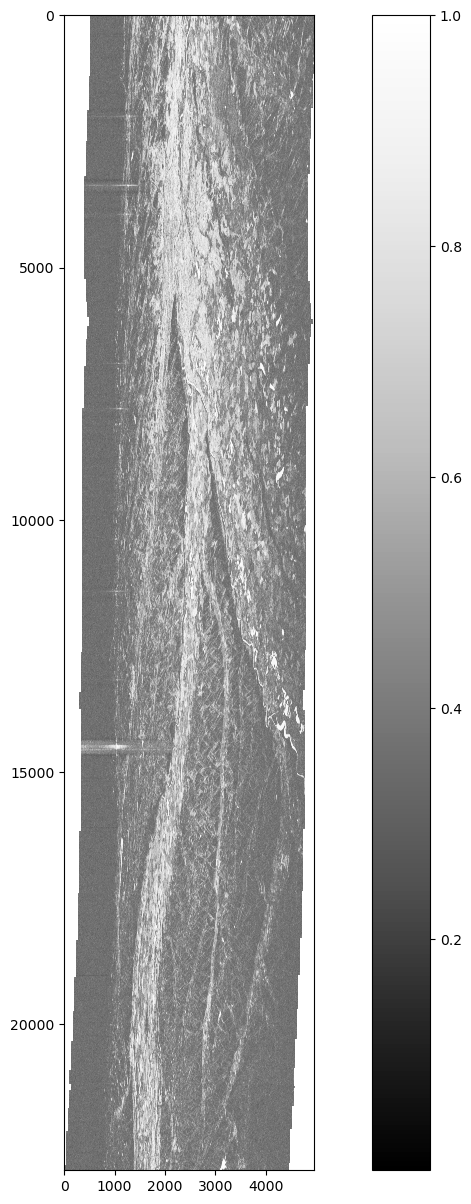

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(coh, cmap = "Greys_r")
plt.colorbar()

## Observe features changes across time
### List and read files in order

In [6]:
files =glob.glob(output_path+'/SWOT_L1B_HR_SLC_*_PIC0_*.nc' )

# sort files according to the first digits found (cycle) included in the filename, you can do as following:
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
files

['/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_017_320_078R_20240630T111930_20240630T111941_PIC0_01.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_010_320_078R_20240205T100400_20240205T100410_PIC0_01.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_015_320_078R_20240519T174922_20240519T174933_PIC0_01.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_011_320_078R_20240226T064905_20240226T064916_PIC0_01.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_014_320_078R_20240428T210417_20240428T210428_PIC0_01.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_013_320_078R_20240408T001912_20240408T001923_PIC0_01.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_018_320_078R_20240721T080436_20240721T080447_PIC0_02.nc',
 '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/SLC/SWOT_L1B_HR_SLC_016_320_078R_20240609T1434

In [7]:
l0, l1 = 1000, 2000
c0, c1 = 2000, 3000

 
snapshots=[]
labels=[]
for slc_name in files:
    
    # opening the dataset without group to get the attributes from medatata
    ds = xr.open_dataset(os.path.join(output_path, slc_name), group = 'slc')
    cycle_number = os.path.basename(slc_name).split("_")[4]
    
    # Compute
    slc_plus_y = ds['slc_plus_y'][:,:,0]+1j*ds['slc_plus_y'][:,:,1]
    slc_minus_y = ds['slc_minus_y'][:,:,0]+1j*ds['slc_minus_y'][:,:,1]
    
    slc_plus_y_ml = convolve2d(ds['slc_plus_y'][:,:,0]+1j*ds['slc_plus_y'][:,:,1], np.ones([7,1])/7.)[::7,:]
    slc_minus_y_ml = convolve2d(ds['slc_minus_y'][:,:,0]+1j*ds['slc_minus_y'][:,:,1], np.ones([7,1])/7.)[::7,:]
    
    # save the computed image for later use
    snapshots.append(10*np.log10(np.abs(slc_plus_y_ml)[l0:l1, c0:c1]))
    labels.append(cycle_number)
    

### Plot the animation

matplotlib ArtistAnimation allows to loop over a list of images (snapshots) in an animated plot.

In [8]:
fig = plt.figure(0)
plt.title("Power right azimuth multilooking")
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in each frame
container = []
for i in range(len(snapshots)):
    im = plt.imshow(snapshots[i], animated=True,vmin=15, vmax=30, cmap="Greys_r")
    # title = ax.text(0.5,1.05,"Title {}".format(i), ha="center", transform=ax.transAxess )
    
    container.append([im])

plt.colorbar(label="Power [dB]")
    
ani = animation.ArtistAnimation(fig, container)

plt.close(0)

HTML(ani.to_jshtml())

### Analysis

You can see the rivers and features in the image move across time because the basckatter is not geolocated as it is provided in azimuth/range referential.



### Saving the animation
It is possible to save the animation as a video or a gif image

In [9]:
ani.save('SLC_animation.mp4')

TIP: for windows, use writer=animation.PillowWriter(fps=30) )

In [10]:
ani.save('SLC_animation.gif', writer='imagemagick', fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.
